In [2]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ViT_B_16_Weights.IMAGENET1K_V1
vit = vit_b_16(weights=weights)

# Freeze the backbone
for param in vit.parameters():
    param.requires_grad = False

# Replace classification head with Identity to extract features
vit.heads = nn.Identity()

vit.eval()
vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [4]:
# Test transform (no augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

train_features, train_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = vit(images)  # Output: [B, 768]
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)


test_features, test_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = vit(images)  # Output: [B, 768]
        test_features.append(features.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)


train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]
100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


In [35]:
epochs = 50
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# classifier = nn.Linear(768, 10).to(device)
# Linear classifier with Dropout
classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 10)
).to(device)


optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    progress_bar = tqdm(trainloader, desc="Training", leave=False)

    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'Batch Loss': f"{loss.item():.4f}",
            'Acc': f"{100 * correct / total:.2f}%"
        })

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    scheduler.step()
    print(f"Learning Rate after epoch {epoch+1}: {scheduler.get_last_lr()[0]:.6f}")

    classifier.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Epoch [1/50]


Epoch [1/50] - Avg Loss: 0.2302, Accuracy: 92.98%
Learning Rate after epoch 1: 0.000450
Test Loss: 0.1562, Test Accuracy: 94.95%

Epoch [2/50]


Epoch [2/50] - Avg Loss: 0.1604, Accuracy: 94.67%
Learning Rate after epoch 2: 0.000405
Test Loss: 0.1469, Test Accuracy: 95.06%

Epoch [3/50]


Epoch [3/50] - Avg Loss: 0.1485, Accuracy: 94.96%
Learning Rate after epoch 3: 0.000365
Test Loss: 0.1420, Test Accuracy: 95.25%

Epoch [4/50]


Epoch [4/50] - Avg Loss: 0.1385, Accuracy: 95.42%
Learning Rate after epoch 4: 0.000328
Test Loss: 0.1432, Test Accuracy: 95.02%

Epoch [5/50]


Epoch [5/50] - Avg Loss: 0.1314, Accuracy: 95.49%
Learning Rate after epoch 5: 0.000295
Test Loss: 0.1346, Test Accuracy: 95.52%

Epoch [6/50]


Epoch [6/50] - Avg Loss: 0.1242, Accuracy: 95.85%
Learning Rate after epoch 6: 0.000266
Test Loss: 0.1298, Test Accuracy: 95.61%

Epoch [7/50]


Epoch [7/50] - Avg Loss: 0.1176, Accuracy: 96.01%
Learning Rate after epoch 7: 0.000239
Test Loss: 0.1282, Test Accuracy: 95.78%

Epoch [8/50]


Epoch [8/50] - Avg Loss: 0.1128, Accuracy: 96.18%
Learning Rate after epoch 8: 0.000215
Test Loss: 0.1277, Test Accuracy: 95.65%

Epoch [9/50]


Epoch [9/50] - Avg Loss: 0.1076, Accuracy: 96.34%
Learning Rate after epoch 9: 0.000194
Test Loss: 0.1272, Test Accuracy: 95.57%

Epoch [10/50]


Epoch [10/50] - Avg Loss: 0.1032, Accuracy: 96.42%
Learning Rate after epoch 10: 0.000174
Test Loss: 0.1236, Test Accuracy: 95.86%

Epoch [11/50]


Epoch [11/50] - Avg Loss: 0.1017, Accuracy: 96.57%
Learning Rate after epoch 11: 0.000157
Test Loss: 0.1222, Test Accuracy: 95.98%

Epoch [12/50]


Epoch [12/50] - Avg Loss: 0.0974, Accuracy: 96.71%
Learning Rate after epoch 12: 0.000141
Test Loss: 0.1217, Test Accuracy: 95.93%

Epoch [13/50]


Epoch [13/50] - Avg Loss: 0.0953, Accuracy: 96.78%
Learning Rate after epoch 13: 0.000127
Test Loss: 0.1221, Test Accuracy: 95.93%

Epoch [14/50]


Epoch [14/50] - Avg Loss: 0.0926, Accuracy: 96.89%
Learning Rate after epoch 14: 0.000114
Test Loss: 0.1212, Test Accuracy: 95.86%

Epoch [15/50]


Epoch [15/50] - Avg Loss: 0.0899, Accuracy: 96.99%
Learning Rate after epoch 15: 0.000103
Test Loss: 0.1193, Test Accuracy: 95.99%

Epoch [16/50]


Epoch [16/50] - Avg Loss: 0.0875, Accuracy: 97.05%
Learning Rate after epoch 16: 0.000093
Test Loss: 0.1202, Test Accuracy: 95.86%

Epoch [17/50]


Epoch [17/50] - Avg Loss: 0.0869, Accuracy: 97.16%
Learning Rate after epoch 17: 0.000083
Test Loss: 0.1186, Test Accuracy: 96.03%

Epoch [18/50]


Epoch [18/50] - Avg Loss: 0.0827, Accuracy: 97.35%
Learning Rate after epoch 18: 0.000075
Test Loss: 0.1165, Test Accuracy: 95.92%

Epoch [19/50]


Epoch [19/50] - Avg Loss: 0.0810, Accuracy: 97.37%
Learning Rate after epoch 19: 0.000068
Test Loss: 0.1182, Test Accuracy: 95.95%

Epoch [20/50]


Epoch [20/50] - Avg Loss: 0.0795, Accuracy: 97.40%
Learning Rate after epoch 20: 0.000061
Test Loss: 0.1164, Test Accuracy: 96.04%

Epoch [21/50]


Epoch [21/50] - Avg Loss: 0.0786, Accuracy: 97.43%
Learning Rate after epoch 21: 0.000055
Test Loss: 0.1164, Test Accuracy: 95.99%

Epoch [22/50]


Epoch [22/50] - Avg Loss: 0.0767, Accuracy: 97.48%
Learning Rate after epoch 22: 0.000049
Test Loss: 0.1157, Test Accuracy: 95.97%

Epoch [23/50]


Epoch [23/50] - Avg Loss: 0.0762, Accuracy: 97.55%
Learning Rate after epoch 23: 0.000044
Test Loss: 0.1153, Test Accuracy: 95.96%

Epoch [24/50]


Epoch [24/50] - Avg Loss: 0.0756, Accuracy: 97.64%
Learning Rate after epoch 24: 0.000040
Test Loss: 0.1150, Test Accuracy: 96.11%

Epoch [25/50]


Epoch [25/50] - Avg Loss: 0.0745, Accuracy: 97.54%
Learning Rate after epoch 25: 0.000036
Test Loss: 0.1159, Test Accuracy: 96.14%

Epoch [26/50]


Epoch [26/50] - Avg Loss: 0.0733, Accuracy: 97.70%
Learning Rate after epoch 26: 0.000032
Test Loss: 0.1154, Test Accuracy: 96.10%

Epoch [27/50]


Epoch [27/50] - Avg Loss: 0.0728, Accuracy: 97.65%
Learning Rate after epoch 27: 0.000029
Test Loss: 0.1155, Test Accuracy: 96.16%

Epoch [28/50]


Epoch [28/50] - Avg Loss: 0.0715, Accuracy: 97.73%
Learning Rate after epoch 28: 0.000026
Test Loss: 0.1159, Test Accuracy: 96.04%

Epoch [29/50]


Epoch [29/50] - Avg Loss: 0.0723, Accuracy: 97.67%
Learning Rate after epoch 29: 0.000024
Test Loss: 0.1152, Test Accuracy: 96.12%

Epoch [30/50]


Epoch [30/50] - Avg Loss: 0.0700, Accuracy: 97.78%
Learning Rate after epoch 30: 0.000021
Test Loss: 0.1146, Test Accuracy: 96.08%

Epoch [31/50]


Epoch [31/50] - Avg Loss: 0.0696, Accuracy: 97.86%
Learning Rate after epoch 31: 0.000019
Test Loss: 0.1149, Test Accuracy: 96.08%

Epoch [32/50]


Epoch [32/50] - Avg Loss: 0.0691, Accuracy: 97.86%
Learning Rate after epoch 32: 0.000017
Test Loss: 0.1149, Test Accuracy: 96.15%

Epoch [33/50]


Epoch [33/50] - Avg Loss: 0.0703, Accuracy: 97.81%
Learning Rate after epoch 33: 0.000015
Test Loss: 0.1149, Test Accuracy: 96.08%

Epoch [34/50]


Epoch [34/50] - Avg Loss: 0.0686, Accuracy: 97.86%
Learning Rate after epoch 34: 0.000014
Test Loss: 0.1144, Test Accuracy: 96.10%

Epoch [35/50]


Epoch [35/50] - Avg Loss: 0.0684, Accuracy: 97.87%
Learning Rate after epoch 35: 0.000013
Test Loss: 0.1145, Test Accuracy: 96.08%

Epoch [36/50]


Epoch [36/50] - Avg Loss: 0.0688, Accuracy: 97.87%
Learning Rate after epoch 36: 0.000011
Test Loss: 0.1141, Test Accuracy: 96.14%

Epoch [37/50]


Epoch [37/50] - Avg Loss: 0.0670, Accuracy: 97.95%
Learning Rate after epoch 37: 0.000010
Test Loss: 0.1144, Test Accuracy: 96.15%

Epoch [38/50]


Epoch [38/50] - Avg Loss: 0.0687, Accuracy: 97.79%
Learning Rate after epoch 38: 0.000009
Test Loss: 0.1146, Test Accuracy: 96.12%

Epoch [39/50]


Epoch [39/50] - Avg Loss: 0.0681, Accuracy: 97.86%
Learning Rate after epoch 39: 0.000008
Test Loss: 0.1143, Test Accuracy: 96.08%

Epoch [40/50]


Epoch [40/50] - Avg Loss: 0.0671, Accuracy: 97.88%
Learning Rate after epoch 40: 0.000007
Test Loss: 0.1144, Test Accuracy: 96.14%

Epoch [41/50]


Epoch [41/50] - Avg Loss: 0.0676, Accuracy: 97.92%
Learning Rate after epoch 41: 0.000007
Test Loss: 0.1145, Test Accuracy: 96.11%

Epoch [42/50]


Epoch [42/50] - Avg Loss: 0.0679, Accuracy: 97.92%
Learning Rate after epoch 42: 0.000006
Test Loss: 0.1142, Test Accuracy: 96.07%

Epoch [43/50]


Epoch [43/50] - Avg Loss: 0.0681, Accuracy: 97.87%
Learning Rate after epoch 43: 0.000005
Test Loss: 0.1142, Test Accuracy: 96.12%

Epoch [44/50]


Epoch [44/50] - Avg Loss: 0.0663, Accuracy: 98.00%
Learning Rate after epoch 44: 0.000005
Test Loss: 0.1142, Test Accuracy: 96.13%

Epoch [45/50]


Epoch [45/50] - Avg Loss: 0.0678, Accuracy: 97.89%
Learning Rate after epoch 45: 0.000004
Test Loss: 0.1142, Test Accuracy: 96.10%

Epoch [46/50]


Epoch [46/50] - Avg Loss: 0.0669, Accuracy: 97.94%
Learning Rate after epoch 46: 0.000004
Test Loss: 0.1142, Test Accuracy: 96.11%

Epoch [47/50]


Epoch [47/50] - Avg Loss: 0.0666, Accuracy: 97.99%
Learning Rate after epoch 47: 0.000004
Test Loss: 0.1139, Test Accuracy: 96.13%

Epoch [48/50]


Epoch [48/50] - Avg Loss: 0.0652, Accuracy: 98.01%
Learning Rate after epoch 48: 0.000003
Test Loss: 0.1139, Test Accuracy: 96.16%

Epoch [49/50]


Epoch [49/50] - Avg Loss: 0.0654, Accuracy: 98.04%
Learning Rate after epoch 49: 0.000003
Test Loss: 0.1139, Test Accuracy: 96.13%

Epoch [50/50]


Epoch [50/50] - Avg Loss: 0.0663, Accuracy: 97.94%
Learning Rate after epoch 50: 0.000003
Test Loss: 0.1138, Test Accuracy: 96.11%


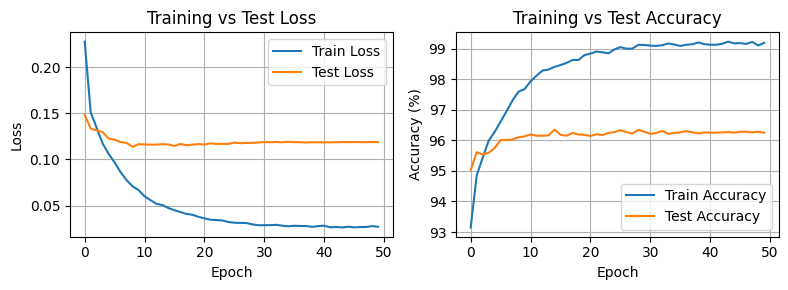

In [33]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
